Group 5

Julia Aptekar, DePaul University, japtekar@depaul.edu

John Leniart, DePaul University, jleniart@depaul.edu

Arham Mehdi, DePaul University kmehdi@depaul.edu

Natalie Olechno, DePaul University, nolechno@depaul.edu

**Model 3**

#### Step 1: Import packages, load and clean data

In [29]:
# Import packages
#load on GPU
import os
import time
import re
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import transformers
from transformers import BertTokenizer, BertModel

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)


cuda


BERT model with huggingface PyTorch library classification of program descriptions to outcome, genome, and impact area.

In [30]:
# Load in dataset
input_file = "./input/Combined Data.xlsx"
print(f"Loading data from {input_file}")
df = pd.read_excel(input_file)

Loading data from ./input/Combined Data.xlsx


Preprocessing

In [31]:
# Clean data

# Drop null rows
df = df.dropna()

# Remove special characters from programdescription
# Leaves letters, numbers, and some punctuation (colon, period, comma, apostraphe, hyphen)
df['programdescription'] = [re.sub(r"[^A-Za-z0-9 :.,'-]+", "", x) for x in df['programdescription']]

# Ensure outcomeID is of type integer
df['outcomeid'] = df['outcomeid'].astype(int)

#mapping dict from outcomeid to outcome
outcomeid_to_outcome = dict(zip(df['outcomeid'], df['outcome']))

In [32]:
print(df.shape)
print(df.info())
print(df.nunique())

(10851, 6)
<class 'pandas.core.frame.DataFrame'>
Index: 10851 entries, 0 to 11057
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   programreportid     10851 non-null  int64 
 1   programdescription  10851 non-null  object
 2   impactarea          10851 non-null  object
 3   genome              10851 non-null  object
 4   outcome             10851 non-null  object
 5   outcomeid           10851 non-null  int32 
dtypes: int32(1), int64(1), object(4)
memory usage: 551.0+ KB
None
programreportid       10851
programdescription     8060
impactarea               12
genome                   50
outcome                 203
outcomeid               289
dtype: int64


#### Prepare the data for BERT

In [34]:
# Encode labels

# Initialize encoders
impact_encoder = LabelEncoder()
genome_encoder = LabelEncoder()
outcomeid_encoder = LabelEncoder()

# Fit and transform labels
df['impactarea'] = impact_encoder.fit_transform(df['impactarea'])
df['genome'] = genome_encoder.fit_transform(df['genome'])
df['outcomeid'] = outcomeid_encoder.fit_transform(df['outcomeid'])

This train-test split code ensures stratified distribution of outcomeid labels while addressing the severe class imbalance. In the dataset, some outcomeid's only appeared once, which made it impossible for train_test_split to work properly. So, this code identifies each single-instance outcomeid, and duplicates it. It then identifies each outcomeid that appears only twice and manually splits the instances, so the train set and the test set can have one each. Then, the rest of the observations are split using train_test_split with stratification and then combined with the manually-split rows.
This ensures a stratified split while also ensuring that both the train and test datasets have at least one observation for each outcome to both train and test on.

In [35]:
# Identify which outcomeids appear only once in the dataset, label them "rare"
rare_classes = df['outcomeid'].value_counts()
rare_classes = rare_classes[rare_classes == 1].index

print("Rare Classes Before Duplication:", rare_classes.tolist())

# Duplicate rare class samples
for cls in rare_classes:
    df = pd.concat([df, df[df['outcomeid'] == cls]], ignore_index=True)

# Find small classes (only 2 instances)
small_classes = df['outcomeid'].value_counts()
small_classes = small_classes[small_classes == 2].index

# Separate these classes from larger dataset before train-test split
df_small = df[df['outcomeid'].isin(small_classes)]
df_rest = df[~df['outcomeid'].isin(small_classes)]

# Split the small classes manually, one in each set
df_small_train = df_small.groupby('outcomeid').sample(n=1, random_state=42)
df_small_val = df_small.drop(df_small_train.index)

# Split the remaining dataset using stratification
train_texts, val_texts, train_impacts, val_impacts, train_genomes, val_genomes, train_outcomeids, val_outcomeids = train_test_split(
    df_rest['programdescription'], df_rest['impactarea'], df_rest['genome'], df_rest['outcomeid'],
    test_size=0.2, stratify=df_rest['outcomeid'], random_state=42)

# Merge small classes back into train/val sets
train_texts = pd.concat([train_texts, df_small_train['programdescription']])
val_texts = pd.concat([val_texts, df_small_val['programdescription']])

train_impacts = pd.concat([train_impacts, df_small_train['impactarea']])
val_impacts = pd.concat([val_impacts, df_small_val['impactarea']])

train_genomes = pd.concat([train_genomes, df_small_train['genome']])
val_genomes = pd.concat([val_genomes, df_small_val['genome']])

train_outcomeids = pd.concat([train_outcomeids, df_small_train['outcomeid']])
val_outcomeids = pd.concat([val_outcomeids, df_small_val['outcomeid']])

# Check final distribution
print(f"Train OutcomeIDs: {train_outcomeids.nunique()}")
print(f"Val OutcomeIDs: {val_outcomeids.nunique()}")


Rare Classes Before Duplication: [174, 216, 243, 173, 217, 213, 241, 122, 244, 113, 154, 90, 219, 262, 83, 220, 198, 185]
Train OutcomeIDs: 289
Val OutcomeIDs: 289


In [36]:
## Ensure no unique values were lost in either set
print(train_texts.nunique())
print(train_impacts.nunique())
print(train_genomes.nunique())
print(train_outcomeids.nunique())

print("Now the validation set")
print(val_texts.nunique())
print(val_impacts.nunique())
print(val_genomes.nunique())
print(val_outcomeids.nunique())

6684
12
50
289
Now the validation set
1983
12
50
289


To apply pre-trained BERT, data must be tokenized with a BERT tokenizer.
Formatting for BERT
- All sentences must be a single fixed length
- Max sentence length is 256 tokens

In [37]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [38]:
# Custom dataset class: tokenizes and converts to tensors

class CustomDataset(Dataset):
    def __init__(self, descriptions, impact_labels, genome_labels, outcome_labels, tokenizer, max_len=256, encoders=None):
        self.descriptions = descriptions  # Raw text
        self.impact_labels = impact_labels  # Category labels
        self.genome_labels = genome_labels
        self.outcome_labels = outcome_labels
        self.tokenizer = tokenizer  # BERT tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.descriptions)

    def __getitem__(self, idx):
        # Tokenize text input
        encoding = self.tokenizer(
            self.descriptions[idx],
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # convert tokenized text input into tensors and return
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'impact_label': torch.tensor(self.impact_labels[idx], dtype=torch.long),
            'genome_label': torch.tensor(self.genome_labels[idx], dtype=torch.long),
            'outcome_label': torch.tensor(self.outcome_labels[idx], dtype=torch.long),
        }


In [39]:
# Set batch_size
batch_size = 16

In [40]:
# Create dataset and dataloaders
train_dataset = CustomDataset(train_texts.tolist(), train_impacts.tolist(), train_genomes.tolist(),
                              train_outcomeids.tolist(), tokenizer)
val_dataset = CustomDataset(val_texts.tolist(), val_impacts.tolist(), val_genomes.tolist(),
                            val_outcomeids.tolist(), tokenizer)

# Dataloaders will save memory in the training step
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=RandomSampler(train_dataset), pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, sampler=SequentialSampler(val_dataset), pin_memory=True)



#### Model Setup

In [41]:
# Define hierarchical BERT Model - Model Architecture
class HierarchicalBERT(nn.Module):
    def __init__(self, num_impact, num_genome, num_outcome):
        super(HierarchicalBERT, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.dropout = nn.Dropout(0.3)

        # Classification heads
        self.impact_classifier = nn.Linear(self.bert.config.hidden_size, num_impact)
        self.genome_classifier = nn.Linear(self.bert.config.hidden_size, num_genome)
        self.outcome_classifier = nn.Linear(self.bert.config.hidden_size, num_outcome)


    def forward(self, input_ids, attention_mask, impact_labels=None, genome_labels=None, outcome_labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        impact_logits = self.impact_classifier(pooled_output)
        genome_logits = self.genome_classifier(pooled_output)
        outcome_logits = self.outcome_classifier(pooled_output)

        return impact_logits, genome_logits, outcome_logits

    def predict(self, input_ids, attention_mask):
        impact_logits, genome_logits, outcome_logits = self.forward(input_ids, attention_mask)

        impact_preds = torch.argmax(impact_logits, dim=1)
        genome_preds = torch.argmax(genome_logits, dim=1)
        outcome_preds = torch.argmax(outcome_logits, dim=1)

        return impact_preds, genome_preds, outcome_preds


In [42]:
# Define Focal Loss function, adjusts loss per level of hierarchy
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # Probability of correct class
        focal_loss = (1 - pt) ** self.gamma * ce_loss  # Apply focusing factor

        if self.alpha is not None:
            if isinstance(self.alpha, torch.Tensor):
                alpha_t = self.alpha.gather(0, targets)
                focal_loss = alpha_t * focal_loss
            else:
                focal_loss = self.alpha * focal_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Define Focal Loss for each task
impact_loss_fn = FocalLoss(gamma=2.0)
genome_loss_fn = FocalLoss(gamma=2.0)
outcome_loss_fn = FocalLoss(gamma=4.0)  # Stronger focus on outcome


In [43]:
# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HierarchicalBERT(num_impact=12, num_genome=50, num_outcome=289).to(device)

In [44]:
# Define optimizer, loss weights
optimizer = optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_weights = {
    "impact": 1.0,   # Adjust if impact accuracy is much higher/lower than others
    "genome": 1.0,   # Typically balanced with impact
    "outcome": 2.0   # Heavier weight since it's the hardest to predict
}

In [45]:
# Time helper function
import time
import datetime

# helpers: time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

Execution

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [47]:
# Create training and eval functions
from torch.amp import autocast, GradScaler

scaler = GradScaler("cuda") # Mixed precision scaling improves training runtime

def train(model, train_dataloader, optimizer, device, impact_loss_fn, genome_loss_fn, outcome_loss_fn):

    t0 = time.time() # reset time
    model.train() # put model into training mode
    total_train_loss = 0 # reset total loss per epoch

    impact_weight, genome_weight, outcome_weight = loss_weights

    # track each metric for each task
    impact_correct, genome_correct, outcome_correct = 0, 0, 0
    total_examples = 0

    for step, batch in enumerate(train_dataloader):

        batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()} # speeds up transfers since pin_memory=True enabled

        if step % 40 == 0 and step != 0: #update progress every 40 batches
            elapsed = format_time(time.time() - t0) #elpased time in minutes
            print(f'  Batch {step:>5,} of {len(train_dataloader):>5,}. Elapsed: {elapsed}.') #report progress

        # send input ids and attention mask and all labels in our batch from dataloader to our gpu device
        input_ids, attention_mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
        impact_labels = batch['impact_label'].to(device)
        genome_labels = batch['genome_label'].to(device)
        outcome_labels = batch['outcome_label'].to(device)

        # clear previous optimizer gradients
        optimizer.zero_grad()

        # AMP: Run forward pass in automatic mixed precision
        with autocast(device_type="cuda"):

            # forward pass
            impact_logits, genome_logits, outcome_logits = model(input_ids, attention_mask)

            # calculate weighted loss for each level of hierarchy
            impact_loss = impact_loss_fn(impact_logits, impact_labels) * loss_weights["impact"]
            genome_loss = genome_loss_fn(genome_logits, genome_labels) * loss_weights["genome"]
            outcome_loss = outcome_loss_fn(outcome_logits, outcome_labels) * loss_weights["outcome"]

            # calculate total loss for batch
            total_batch_loss = impact_loss + genome_loss + outcome_loss


        scaler.scale(total_batch_loss).backward() # backward pass
        
        scaler.step(optimizer) # take step with computed gradients 
        scaler.update() # updates mixed precision scaler for next iteration


        total_train_loss += total_batch_loss.item() # update total loss
        total_examples += input_ids.size(0) #count batch samples

        #get predictions & track accuracy
        _, impact_preds = torch.max(impact_logits, dim=1)
        _, genome_preds = torch.max(genome_logits, dim=1)
        _, outcome_preds = torch.max(outcome_logits, dim=1)
        #count correct predictions
        impact_correct += (impact_preds == impact_labels).sum().item()
        genome_correct += (genome_preds == genome_labels).sum().item()
        outcome_correct += (outcome_preds == outcome_labels).sum().item()

    #calc training metrics
    avg_train_loss = total_train_loss / len(train_dataloader)
    impact_accuracy = impact_correct / total_examples
    genome_accuracy = genome_correct / total_examples
    outcome_accuracy = outcome_correct / total_examples
    training_time = format_time(time.time() - t0)

    return avg_train_loss, impact_accuracy, genome_accuracy, outcome_accuracy, training_time



def evaluate(model, val_dataloader, device, impact_loss_fn, genome_loss_fn, outcome_loss_fn):

    t0 = time.time()
    model.eval() # model evaluation mode

    # store all predictions and labels
    all_impact_preds, all_genome_preds, all_outcome_preds = [], [], []
    all_impact_labels, all_genome_labels, all_outcome_labels = [], [], []

    total_eval_loss = 0


    with torch.no_grad():
        for batch in val_dataloader:
            batch = {k: v.to(device, non_blocking=True) for k, v in batch.items()}

            # unpack data from dataloader, send to device
            input_ids, attention_mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
            impact_labels = batch['impact_label'].to(device)
            genome_labels = batch['genome_label'].to(device)
            outcome_labels = batch['outcome_label'].to(device)

            # Forward pass
            impact_logits, genome_logits, outcome_logits = model(input_ids, attention_mask)

            # calculate validation loss for each level
            impact_loss = impact_loss_fn(impact_logits, impact_labels) * loss_weights["impact"]
            genome_loss = genome_loss_fn(genome_logits, genome_labels) * loss_weights["genome"]
            outcome_loss = outcome_loss_fn(outcome_logits, outcome_labels) * loss_weights["outcome"]

            # calculate total loss for batch
            eval_batch_loss = impact_loss + genome_loss + outcome_loss

            total_eval_loss += eval_batch_loss.item()

            # Predictions (select highest probability class)
            impact_preds = torch.argmax(impact_logits, dim=1)
            genome_preds = torch.argmax(genome_logits, dim=1)
            outcome_preds = torch.argmax(outcome_logits, dim=1)

            # Store results
            all_impact_preds.extend(impact_preds.cpu().numpy())
            all_genome_preds.extend(genome_preds.cpu().numpy())
            all_outcome_preds.extend(outcome_preds.cpu().numpy())

            all_impact_labels.extend(impact_labels.cpu().numpy())
            all_genome_labels.extend(genome_labels.cpu().numpy())
            all_outcome_labels.extend(outcome_labels.cpu().numpy())


    #validation metrics
    
    avg_val_loss = total_eval_loss / len(val_dataloader)
    
    # Compute accuracy for each level
    impact_accuracy = accuracy_score(all_impact_labels, all_impact_preds)
    genome_accuracy = accuracy_score(all_genome_labels, all_genome_preds)
    outcome_accuracy = accuracy_score(all_outcome_labels, all_outcome_preds)

    impact_precision = precision_score(all_impact_labels, all_impact_preds, average='macro', zero_division=0)
    impact_recall = recall_score(all_impact_labels, all_impact_preds, average='macro')
    genome_precision = precision_score(all_genome_labels, all_genome_preds, average='macro', zero_division=0)
    genome_recall = recall_score(all_genome_labels, all_genome_preds, average='macro')
    outcome_precision = precision_score(all_outcome_labels, all_outcome_preds, average='macro', zero_division=0)
    outcome_recall = recall_score(all_outcome_labels, all_outcome_preds, average='macro')
    
    outcome_f1 = f1_score(all_outcome_labels, all_outcome_preds, average='macro')
    
    # measure validation time
    validation_time = format_time(time.time() - t0)
    
    
    return avg_val_loss, impact_accuracy, genome_accuracy, outcome_accuracy, outcome_f1, validation_time, impact_precision, impact_recall, genome_precision, genome_recall, outcome_precision, outcome_recall

In [48]:
# training loop

seed_val = 42
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

#best_model_dir = "./working"  # Directory to save the best model
#os.makedirs(best_model_dir, exist_ok=True)  # Create folder if it doesn't exist
best_model_path = './working/best_hierarchical_model3.pt'

# Store validation accuracy history over epochs
accuracy_history = {"impact": [], "genome": [], "outcome": []}

# Store validation loss over epochs
loss_history = []

# store loss weights over epochs
loss_weight_history = {"impact": [], "genome": [], "outcome": []}

# Store outcome f1 per epoch
f1_history = []
epochs = 12

print("\n Training Hierarchical BERT Model...")
for epoch_i in range(epochs):
    print(f'\nTraining epoch {epoch_i + 1} out of {epochs}')
    avg_train_loss, train_impact_acc, train_genome_acc, train_outcome_acc, train_time = train(model, train_dataloader, optimizer, device, impact_loss_fn, genome_loss_fn, outcome_loss_fn)
    print(f"  Average training loss: {avg_train_loss:.4f}")
    print(f"  Impact Area Accuracy: {train_impact_acc:.4f}")
    print(f"  Genome Accuracy: {train_genome_acc:.4f}")
    print(f"  Outcome Accuracy: {train_outcome_acc:.4f}")
    print(f"  Training took: {train_time}")

    print(f" Running validation...")
    avg_val_loss, impact_acc, genome_acc, outcome_acc, outcome_f1, val_time, impact_precision, impact_recall, genome_precision, genome_recall, outcome_precision, outcome_recall = evaluate(model, val_dataloader, device, impact_loss_fn, genome_loss_fn, outcome_loss_fn)

    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  Impact Area Accuracy: {impact_acc:.4f}")
    print(f"  Genome Accuracy: {genome_acc:.4f}")
    print(f"  Outcome Accuracy: {outcome_acc:.4f}")
    print(f"  Validation took: {val_time}")
    
    print(f"Outcome Macro F1 Score: {outcome_f1:.4f}")
    print(f"Outcome Precision: {outcome_precision:.4f}")
    print(f"Outcome Recall: {outcome_recall:.4f}")
    

    # Log validation accuracies per epoch
    accuracy_history["impact"].append(impact_acc)
    accuracy_history["genome"].append(genome_acc)
    accuracy_history["outcome"].append(outcome_acc)

    # Log validation loss per epoch
    loss_history.append(avg_val_loss)
    
    # Log OutcomeID F1 per epoch
    f1_history.append(outcome_f1)

    # Log current loss weights
    loss_weight_history["impact"].append(loss_weights["impact"])
    loss_weight_history["genome"].append(loss_weights["genome"])
    loss_weight_history["outcome"].append(loss_weights["outcome"])

    # dynamically update loss weights per epoch: well-trained levels have their weight reduced, while struggling levels become more important
    if impact_acc > 0.85:  # If impact is well-trained, reduce weight
        loss_weights["impact"] = max(0.5, loss_weights["impact"] * 0.9)
    if genome_acc > 0.80:  # If genome is improving, reduce weight slightly
        loss_weights["genome"] = max(0.7, loss_weights["genome"] * 0.95)
    if outcome_acc < 0.60:  # If outcome is struggling, increase its weight
        loss_weights["outcome"] = min(3.0, loss_weights["outcome"] * 1.1) # consider changing 3 to 4 later but watch for exploding gradients

    print(f"Adjusted Loss Weights: {loss_weights}")      

    # save model at each epoch 
    torch.save({
        'model': model,
        'outcomeid_encoder': outcomeid_encoder,
        'genome_encoder': genome_encoder,
        'impact_encoder': impact_encoder,
        'epoch': epoch_i,
        'f1_score': outcome_f1
    }, best_model_path)

    training_stats.append({
    'epoch': epoch_i + 1,
    'Training Loss': avg_train_loss,
    'Val. Loss': avg_val_loss,
    'Val. Impact Accuracy': impact_acc,
    'Val. Genome Accuracy': genome_acc,
    'Val. Outcome Accuracy': outcome_acc,
    'Val. Impact Precision': impact_precision,
    'Val. Impact Recall': impact_recall,
    'Val. Genome Precision': genome_precision,
    'Val. Genome Recall': genome_recall,
    'Val. Outcome Precision': outcome_precision,
    'Val. Outcome Recall': outcome_recall,
    'Outcome F1 Score': outcome_f1,
    'Training Time': train_time,
    'Validation Time': val_time
    })

print(f"\nTraining complete!")
print(f"Total training took {format_time(time.time() - total_t0)}")
best_checkpoint = torch.load(best_model_path, weights_only=False)
best_model = best_checkpoint['model']
print(f"Best model was from epoch {best_checkpoint['epoch'] + 1}")

# Save final model 
torch.save({
    'model': best_model,
    'outcomeid_encoder': best_checkpoint['outcomeid_encoder'],
    'genome_encoder': best_checkpoint['genome_encoder'],
    'impact_encoder': best_checkpoint['impact_encoder'],
    'epoch': epoch_i,
    'f1_score': outcome_f1,
    'impact_precision': impact_precision,
    'impact_recall': impact_recall,
    'genome_precision': genome_precision,
    'genome_recall': genome_recall,
    'outcome_precision': outcome_precision,
    'outcome_recall': outcome_recall,
    'model_class' : HierarchicalBERT
}, 'hierarchical_bert_model3.pt')


print("Full hierarchical model training complete.")


 Training Hierarchical BERT Model...

Training epoch 1 out of 12
  Batch    40 of   543. Elapsed: 0:00:07.
  Batch    80 of   543. Elapsed: 0:00:15.
  Batch   120 of   543. Elapsed: 0:00:23.
  Batch   160 of   543. Elapsed: 0:00:31.
  Batch   200 of   543. Elapsed: 0:00:38.
  Batch   240 of   543. Elapsed: 0:00:46.
  Batch   280 of   543. Elapsed: 0:00:53.
  Batch   320 of   543. Elapsed: 0:01:01.
  Batch   360 of   543. Elapsed: 0:01:08.
  Batch   400 of   543. Elapsed: 0:01:16.
  Batch   440 of   543. Elapsed: 0:01:23.
  Batch   480 of   543. Elapsed: 0:01:31.
  Batch   520 of   543. Elapsed: 0:01:38.
  Average training loss: 12.7544
  Impact Area Accuracy: 0.6738
  Genome Accuracy: 0.3800
  Outcome Accuracy: 0.1132
  Training took: 0:01:43
 Running validation...
  Validation Loss: 9.5679
  Impact Area Accuracy: 0.8528
  Genome Accuracy: 0.6484
  Outcome Accuracy: 0.1966
  Validation took: 0:00:19
Outcome Macro F1 Score: 0.0404
Outcome Precision: 0.0373
Outcome Recall: 0.0785
Adjust

Evaluate model performance

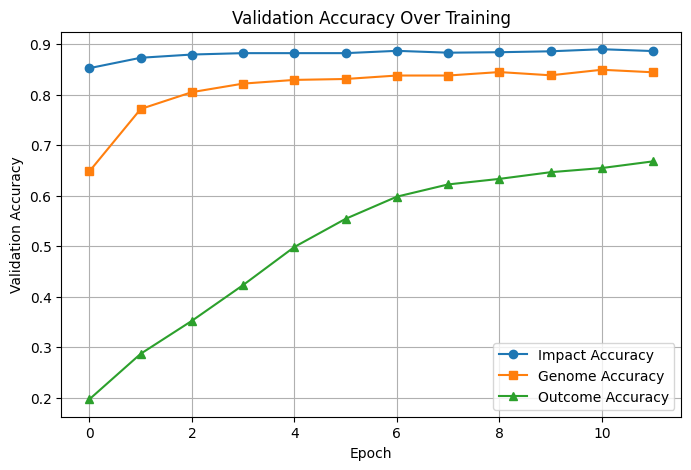

In [49]:
# Plot accuracy trends
plt.figure(figsize=(8, 5))
plt.plot(accuracy_history["impact"], label="Impact Accuracy", marker="o")
plt.plot(accuracy_history["genome"], label="Genome Accuracy", marker="s")
plt.plot(accuracy_history["outcome"], label="Outcome Accuracy", marker="^")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Over Training")
plt.legend()
plt.grid()
plt.show()


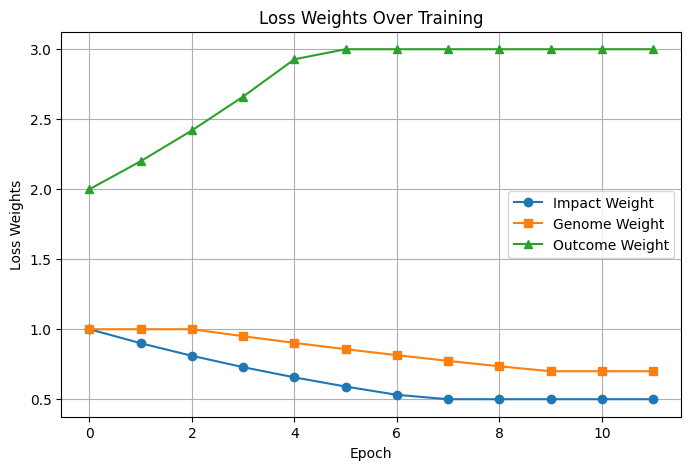

In [50]:
# Plot loss weights trends
plt.figure(figsize=(8, 5))
plt.plot(loss_weight_history["impact"], label="Impact Weight", marker="o")
plt.plot(loss_weight_history["genome"], label="Genome Weight", marker="s")
plt.plot(loss_weight_history["outcome"], label="Outcome Weight", marker="^")
plt.xlabel("Epoch")
plt.ylabel("Loss Weights")
plt.title("Loss Weights Over Training")
plt.legend()
plt.grid()
plt.show()


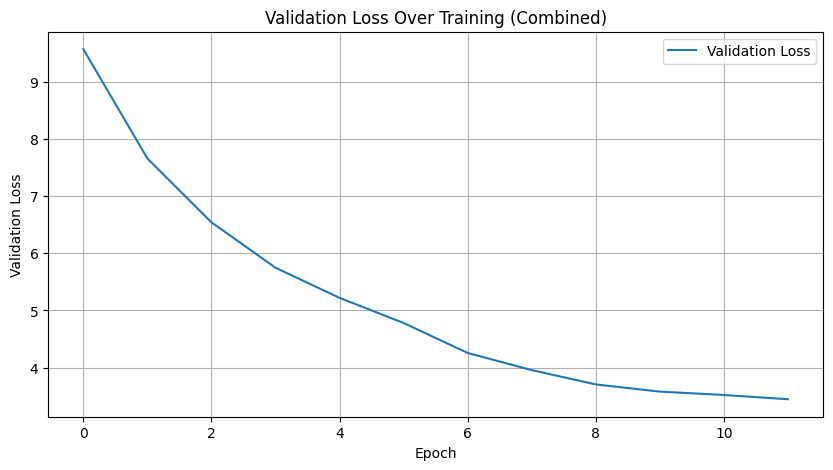

In [51]:
# Plot loss trends

plt.figure(figsize=(10, 5))
plt.plot(loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Over Training (Combined)")
plt.legend()
plt.grid()
plt.show()


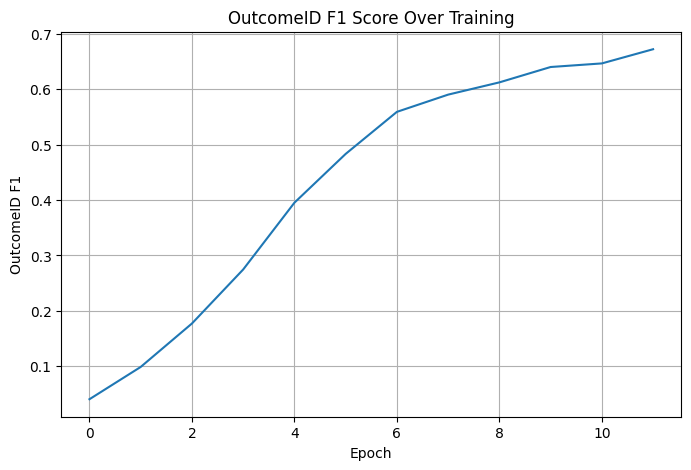

In [52]:
# Plot f1 trends

plt.figure(figsize=(8, 5))
plt.plot(f1_history, label="OutcomeID F1")
plt.xlabel("Epoch")
plt.ylabel("OutcomeID F1")
plt.title("OutcomeID F1 Score Over Training")
#plt.legend()
plt.grid()
plt.show()


In [53]:
from tqdm import tqdm
import re

In [54]:
def predict_outcomes(input_file, model_file, output_file=None):
    #maps outcomeids to outcome
    #outputs predictions

    if output_file is None:
        output_file='predictions.xlsx'

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    #load data
    df=pd.read_excel(input_file)
    
    #map outcomes from input file
    outcome_dict= {}
    if 'outcomeid' in df.columns and 'outcome' in df.columns:
        outcome_mapping= df[['outcomeid', 'outcome']].drop_duplicates()
        outcome_dict= dict(zip(outcome_mapping['outcomeid'], outcome_mapping['outcome']))

    #load model
    #prevent errors
    from torch.serialization import add_safe_globals
    add_safe_globals([HierarchicalBERT])
    try:
        checkpoint= torch.load(model_file, map_location=device, weights_only=False)
    except:
        try:
            checkpoint= torch.load(model_file, map_location=device)
        except:
            checkpoint= torch.load(
                model_file,
                map_location=device,
                pickle_module =torch.serialization.pickle_module,
                weights_only=False
            )

    model= checkpoint['model']
    model.to(device)
    model.eval()

    #get encoders
    outcomeid_encoder= checkpoint.get('outcomeid_encoder')
    genome_encoder= checkpoint.get('genome_encoder')
    impact_encoder= checkpoint.get('impact_encoder')

    print("Initializing tokenizer")
    tokenizer= BertTokenizer.from_pretrained("bert-base-uncased")
    print("Processing program descriptions")
    descriptions = df['programdescription'].fillna("").astype(str).tolist()

    encodings= tokenizer.batch_encode_plus(
        descriptions,
        add_special_tokens=True,
        max_length=240,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids= encodings['input_ids'].to(device)
    attention_mask= encodings['attention_mask'].to(device)

    #make predictions in batches
    batch_size= 16
    total_batches= (len(input_ids) + batch_size - 1) // batch_size

    all_impact_preds= []
    all_genome_preds= []
    all_outcome_preds= []

    with torch.no_grad():
        for i in tqdm(range(0, len(input_ids), batch_size), total=total_batches):
            batch_input_ids = input_ids[i:i+batch_size]
            batch_attention_mask = attention_mask[i:i+batch_size]

            #get predictions
            impact_preds, genome_preds, outcome_preds = model.predict(
                batch_input_ids,
                batch_attention_mask
            )

            all_impact_preds.extend(impact_preds.cpu().numpy())
            all_genome_preds.extend(genome_preds.cpu().numpy())
            all_outcome_preds.extend(outcome_preds.cpu().numpy())

    #convert predictions to labels
    print("Converting predictions to labels...")
    if outcomeid_encoder is not None:
        df['predicted_outcomeid'] = outcomeid_encoder.inverse_transform(all_outcome_preds)
        df['predicted_genome'] = genome_encoder.inverse_transform(all_genome_preds)
        df['predicted_impact_area'] = impact_encoder.inverse_transform(all_impact_preds)

        #map to outcomeid to outcome
        if outcome_dict:
            df['predicted_outcome']= df['predicted_outcomeid'].map(outcome_dict)
    else:
        df['predicted_outcomeid']= all_outcome_preds
        df['predicted_genome_id']= all_genome_preds
        df['predicted_impact_area_id']= all_impact_preds

    #save results
    print(f"Saving predictions to {output_file}")
    df.to_excel(output_file, index=False)
    print("Done!")

    return df

In [55]:
import os
os.listdir('./working')


['best_hierarchical_model3.pt']

In [56]:
predict_outcomes(
    input_file='./input/Combined Data.xlsx',
    model_file="./working/best_hierarchical_model3.pt",
    output_file="./working/predictions.xlsx"
)

Using device: cuda
Initializing tokenizer
Processing program descriptions


100%|████████████████████████████████████████████████████████████████████████████████| 692/692 [01:24<00:00,  8.19it/s]


Converting predictions to labels...
Saving predictions to ./working/predictions.xlsx
Done!


,programreportid,programdescription,impactarea,genome,outcome,outcomeid,predicted_outcomeid,predicted_genome,predicted_impact_area,predicted_outcome
0,76,The Bookmobile is the Maryland Book Bank's mob...,Education,K-12 Student Achievement,Expand Reach and Scale Effective Strategies,377.0,2,K-12 Student Achievement,Education,Improved Academic Skills
1,104,This program provides students with...,Critical Human Needs,Homelessness,Access to Temporary Housing,13.0,852,Youth Development,Youth,Improved Social-Emotional Skills
2,111,"Prepped! enables underserved, low income, and ...",Education,College and Career Readiness,Career Access and Readiness,28.0,28,College and Career Readiness,Education,Career Access and Readiness
3,113,Illinois Action for Children designed and impl...,Education,Early Childhood Education,Network Building and Capacity Development (Org...,510.0,126,Early Childhood Education,Education,Improved Oral Language and Emergent Literacy S...
4,117,Junior Achievement of Tampa Bays Hall of Fame ...,Education,K-12 Student Achievement,"Improved Academic Attitudes, Beliefs, and Moti...",95.0,28,Youth Development,Youth,Career Access and Readiness
...,...,...,...,...,...,...,...,...,...,...
11053,14104,The Blue Whale Initiative is dedicated to enha...,Public Health,Mental and Behavioral Health,Utilization of Mental and Behavioral Health Se...,901.0,901,Mental and Behavioral Health,Public Health,Utilization of Mental and Behavioral Health Se...
11054,14105,The Blue Sky Initiative is dedicated to enhanc...,Public Health,Mental and Behavioral Health,Utilization of Mental and Behavioral Health Se...,901.0,901,Mental and Behavioral Health,Public Health,Utilization of Mental and Behavioral Health Se...
11055,14106,"The Green Leaf Initiative, led by the Emerald ...",Public Health,Mental and Behavioral Health,Utilization of Mental and Behavioral Health Se...,901.0,901,Mental and Behavioral Health,Public Health,Utilization of Mental and Behavioral Health Se...
11056,14107,"The Mindful Pathway Initiative, spearheaded by...",Public Health,Mental and Behavioral Health,Utilization of Mental and Behavioral Health Se...,901.0,901,Mental and Behavioral Health,Public Health,Utilization of Mental and Behavioral Health Se...
